<a href="https://colab.research.google.com/github/quanap5/ColabNote2/blob/master/Minist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## From one-vs-all to Neural network without regularization and with regularization

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

### 1.1 Importing data and module

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import scipy.io as sio
from sklearn.model_selection import  train_test_split
import warnings
warnings.simplefilter('ignore')

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Training set has 55000 samples. But now we just take 20% of this for training

In [0]:
x_train, x_test, y_train, y_test = train_test_split(mnist.train.images, mnist.train.labels, test_size = 0.8)

Show some sample for seeing

In [0]:
def show_num_tf(rows):
  train_nums = np.empty(100)
  fig, ax = plt.subplots(figsize=(10,10))
  j=0
  
  for row in range rows:
    j = j+1
    plt.subplot(10,10,j)
    vect_mat = np.reshape(x_train[row, :], (28, 28))
    plt.imshow(vect_mat, cmap = 'Greys')
    plt.axis('off')
  plt.show()

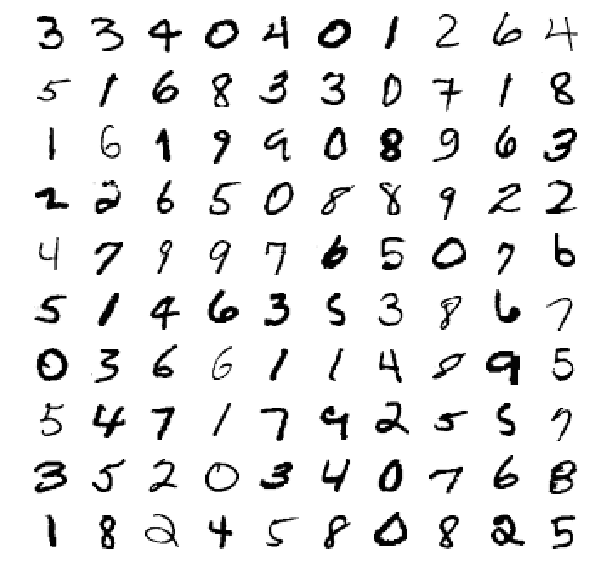

In [25]:
plot_rows = np.random.randint(x_train.shape[0], size=100)
show_num_tf(plot_rows)

### 1.2 One vs All logistic regression

We will regularized one-vs-all logistic regression for training our model. One-vs-all is similar to classification we did on classification problem, except now we are dealing matrix instead of vectors

In [0]:
def add_bias(features):
  size = features.shape[0]
  new_array = np.c_[np.ones(size), features]
  return new_array

X_biased = add_bias(x_train)

In [0]:
tf.reset_default_graph()
L1 = 1.0 #regularization parameter
learning_rate = 0.1
training_epochs = 1000
logs_path = os.path.join(os.getcwd(), 'board')

In [0]:
sample_n, params_n = np.shape(X_biased)
 

with tf.name_scope('Input'):
    y_ = tf.placeholder(tf.float64, [None, 10], name='y_input')
    X_ = tf.placeholder(tf.float64, [None, params_n], name='x_input')

with tf.name_scope('Weights'):
    W = tf.Variable(np.zeros((params_n,10)), name='weight')

with tf.name_scope('Sigmoid'):
    h_ = tf.sigmoid(tf.matmul(X_,W))

# because we are doing one-vs-all classification, it should be element-wise multiply.
# note that axis=0 is needed. 
with tf.name_scope('Cost_fn'):
    cost = tf.reduce_mean(tf.multiply(-y_,tf.log(h_))-tf.multiply(1-y_,tf.log(1-h_)), 
                         axis=0)+0.5*L1*tf.reduce_mean(tf.square(W[1:,:]), axis=0)
    
    tf.summary.scalar('cost', cost)
    
with tf.name_scope('Train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    
with tf.name_scope('Accuracy'):
    prediction = tf.sigmoid(tf.matmul(X_, W))
    y_pred_pf = tf.greater_equal(prediction, 0.5)
    y_pred_pf_float = tf.cast(y_pred_pf, tf.float64)
    mult_mat = tf.multiply(y_pred_pf_float, y_)
    row_sum = tf.reduce_sum(mult_mat, axis=1)
    accuracy = tf.reduce_mean(row_sum)
    tf.summary.scalar('accuracy', accuracy)

cost_history = []
accuracy_history = []
summ = tf.summary.merge_all()

In [0]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logs_path)
writer.add_graph(sess.graph)

for epoch in range(training_epochs):
    sess.run(optimizer, feed_dict={X_:X_biased, y_:y_train})
    cost_value = sess.run(cost, feed_dict={X_:X_biased, y_:y_train})
    acrcy_value = sess.run(accuracy, feed_dict={X_:X_biased, y_:y_train})
    cost_history.append(cost_value)
    accuracy_history.append(acrcy_value)
    

weights = sess.run(W)
sess.close()

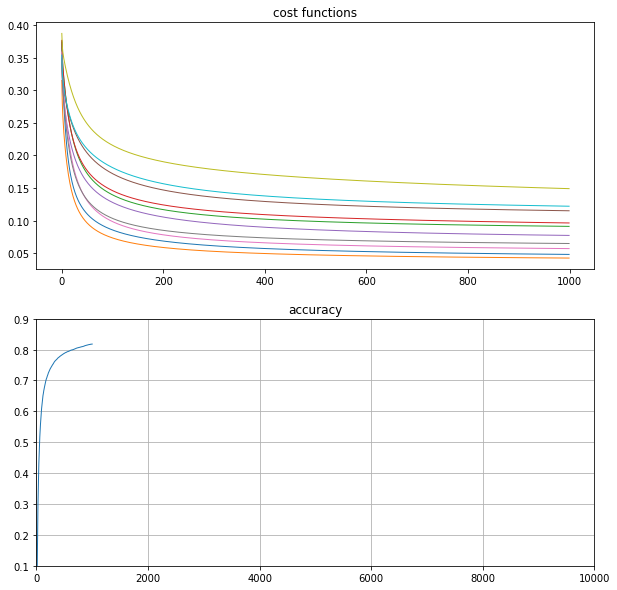

In [37]:
fig, ax = plt.subplots(figsize=(10,10))

plt.xlabel('iterations',fontsize=16)
plt.ylabel('Error', fontsize=16)

plt.subplot(2,1,1)
plt.title('cost functions')
plt.plot(range(training_epochs), cost_history, linewidth=1)
plt.subplot(2,1,2)
plt.title('accuracy')
plt.axis([0,10000,0.1,0.9])
plt.grid(True)
plt.plot(range(training_epochs), accuracy_history, linewidth=1)

plt.show()

We just run 1000 epoch that lead to accuracy of 82%, which is not impressive. Let's show the results of tessting with demostration from image

In [0]:
def show_num_tf_test(rows, weight):
    
    test_nums = np.empty(25)
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    j = 0
    for row in rows:
        j+=1
        plt.subplot(5,5,j)
        vect_mat = np.reshape(x_test[row,:], (28,28))
        plt.imshow(vect_mat, cmap='Greys')
        plt.axis('off')
    plt.show()
    
    vect1 = add_bias(x_test[rows,:])
    prediction = scipy.special.expit(np.matmul(vect1,weight))
    y_pred_pf = np.greater_equal(prediction, 0.5)
    y_pred = np.matmul(y_pred_pf, 
                      np.array([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]))
    print("Our Predictions:")
    print(np.reshape(y_pred, [5,5]))

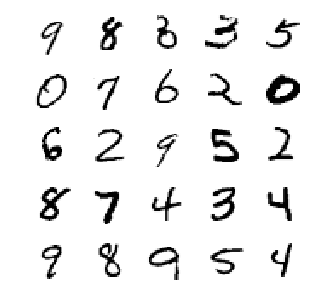

Our Predictions:
[[ 9  8  6  3  5]
 [ 0  7  6  2  0]
 [ 6 10  0  5  2]
 [ 8  7  4  3  4]
 [ 9  0  9  5  4]]


In [39]:
plot_rows = np.random.randint(x_test.shape[0], size=25)
show_num_tf_test(plot_rows, weights)

### 1.3 Neural Network with backpropagation

In [0]:
def add_bias(features):
    size = features.shape[0]
    new_array = np.c_[np.ones(size), features]
    return new_array
    
X_biased = add_bias(x_train)

In [0]:
tf.reset_default_graph()
learning_rate = 0.0001
training_epochs = 1000
logs_path = os.path.join(os.getcwd(),'board')

In [0]:
sample_n, params_n = np.shape(X_biased) #Nx785 if images are 28x28 pixles
layer2_n = 25 

with tf.name_scope('Input'):
    y_ = tf.placeholder(tf.float64, [None, 10], name='y_input')
    X_ = tf.placeholder(tf.float64, [None, params_n], name='x_input')

with tf.name_scope('Weights'):
    W1 = tf.Variable(tf.truncated_normal((params_n, layer2_n), dtype=tf.float64), name='W_1')
    W2 = tf.Variable(tf.truncated_normal((layer2_n+1, 10), dtype=tf.float64), name='W_2')

with tf.name_scope('First_Layer'):
    z2 = tf.matmul(X_,W1)
    a2 = tf.sigmoid(z2)
    a2_ = tf.concat([tf.ones([sample_n, 1], tf.float64), a2], axis=1)

with tf.name_scope('Second_Layer'):
    z3 = tf.matmul(a2_,W2)
    h_ = tf.sigmoid(z3)
    

# In NN, we take the mean over entire dataset and entire nodes of the output layer. 
# That's why axis=0 is removed. 
# In one-vs-all classification though, we did minimize each column of the cost function
# matrix.

with tf.name_scope('Cost_fn'):
    cost = tf.reduce_mean(tf.multiply(-y_,tf.log(h_))-
                          tf.multiply(1-y_,tf.log(1-h_)))
    # +0.5*L1/sample_n*tf.reduce_sum(tf.square(W1[1:,:])+tf.square(W2[1:,:]))
    
    tf.summary.scalar('cost', cost)


def d_sig(z):
    return tf.multiply(tf.sigmoid(z), 1-tf.sigmoid(z))

with tf.name_scope('Back_Prop'):
    delta3 = tf.multiply(h_-y_, d_sig(z3))
    delta2 = tf.multiply(tf.matmul(delta3, tf.transpose(W2[1:,:])), d_sig(z2))
    dJ_W2 = tf.matmul(tf.transpose(a2_), delta3)
    dJ_W1 = tf.matmul(tf.transpose(X_), delta2)


with tf.name_scope('Updating'):    
    update = [tf.assign(W1, tf.subtract(W1,learning_rate*dJ_W1)),
             tf.assign(W2, tf.subtract(W2,learning_rate*dJ_W2))]

#with tf.name_scope('Train'):
#    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    
with tf.name_scope('Accuracy'):
    y_pred_pf = tf.equal(tf.argmax(h_,1), tf.argmax(y_,1))
    y_pred_pf_float = tf.cast(y_pred_pf, tf.float64)
    accuracy = tf.reduce_mean(y_pred_pf_float)
    tf.summary.scalar('accuracy', accuracy)

cost_history = []
accuracy_history = []
summ = tf.summary.merge_all()

In [0]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logs_path)
writer.add_graph(sess.graph)

for epoch in range(training_epochs):
    sess.run(update, feed_dict={X_:X_biased, y_:y_train})
    cost_value = sess.run(cost, feed_dict={X_:X_biased, y_:y_train})
    acrcy_value = sess.run(accuracy, feed_dict={X_:X_biased, y_:y_train})
    cost_history.append(cost_value)
    accuracy_history.append(acrcy_value)

weights1 = sess.run(W1)
weights2 = sess.run(W2)
sess.close()

In [0]:
def show_num_nn_test(rows, weight1, weight2):
    
    test_nums = np.empty(25)
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    j = 0
    for row in rows:
        j+=1
        plt.subplot(5,5,j)
        vect_mat = np.reshape(x_test[row,:], (28,28))
        plt.imshow(vect_mat, cmap='Greys')
        plt.axis('off')
    plt.show()
    
    print('Hidden Layers:')
    fig, ax = plt.subplots(figsize=(5,5))
    j = 0
    for row in rows:
        j+=1
        plt.subplot(5,5,j)
        vect1 = add_bias(x_test[row:row+1,:])
        a2 = scipy.special.expit(np.matmul(vect1,weight1))        
        vect_mat = np.reshape(a2, (5,5))
        plt.imshow(vect_mat, cmap='Greys')
        plt.axis('off')
    plt.show()
    
    print('Our Predictions:')
    vect1 = add_bias(x_test[rows,:])
    a2 = scipy.special.expit(np.matmul(vect1,weight1))
    h_pred = scipy.special.expit(np.matmul(add_bias(a2),weight2))
    y_pred_pf = np.argmax(h_pred,1)
    print(np.reshape(y_pred_pf, [5,5]))

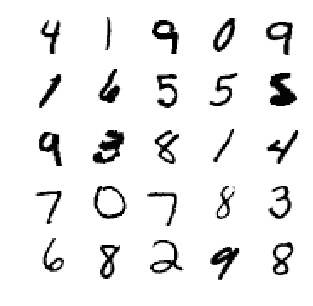

Hidden Layers:


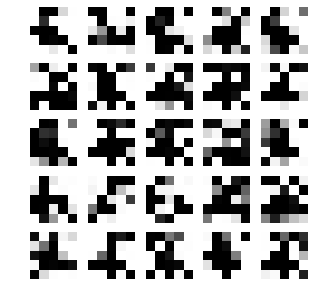

Our Predictions:
[[4 1 4 8 9]
 [1 6 3 3 8]
 [9 8 8 1 4]
 [7 0 7 8 2]
 [6 8 2 4 8]]


In [49]:
plot_rows = np.random.randint(x_test.shape[0], size=25)
show_num_nn_test(plot_rows, weights1, weights2)

## References

[1] [From this github](https://github.com/majidpy/mnist/blob/master/NeuralNet.ipynb)